In [1]:
from pyspark.context import SparkContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import pandas as pd 
import pandas.tools.plotting as pdplt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pyspark.mllib.stat import Statistics
import seaborn as sns
from pylab import savefig

In [2]:
sc = SparkContext.getOrCreate()

## Preprocessing the data using OneHotEncoder

In [3]:
data_path = "../input/HR_comma_sep.csv"
dataset = spark.read.options(header="true", parserLib="univocity", inferSchema="true").csv(data_path)
cols = dataset.columns
print dataset.dtypes

[('satisfaction_level', 'double'), ('last_evaluation', 'double'), ('number_project', 'int'), ('average_montly_hours', 'int'), ('time_spend_company', 'int'), ('Work_accident', 'int'), ('left', 'int'), ('promotion_last_5years', 'int'), ('sales', 'string'), ('salary', 'string')]


In [4]:
categoricalColumns = ["sales", "salary"]
stages = []

for categoricalCol in categoricalColumns: 
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
    encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
    stages += [stringIndexer, encoder]

In [5]:
label_string_indexer = StringIndexer(inputCol = "left", outputCol = "label")
stages += [label_string_indexer]

In [6]:
numericColumns = ['number_project',
                  'average_montly_hours',
                  'time_spend_company',
                  'Work_accident', 
                  'promotion_last_5years']

assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [7]:
print dataset.columns

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']


In [8]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.show()

+-----+--------------------+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|label|            features|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|sales|salary|
+-----+--------------------+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|  1.0|(16,[0,9,11,12,13...|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|sales|   low|
|  1.0|(16,[0,10,11,12,1...|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|sales|medium|
|  1.0|(16,[0,10,11,12,1...|              0.11|           0.88|             7|                 272|                 4|            0|   

## Visualizing the data

In [9]:
dept_dictionary = {'management': 0,
                   'product_mng': 1, 
                   'hr': 2, 
                   'marketing': 3,
                   'support': 4,
                   'sales': 5, 
                   'RandD': 6,
                   'IT': 7,
                   'technical': 8,
                   'accounting': 9}
salary_dict = {'low': 60000, 'medium': 100000, 'high': 150000}

heatMapdata = dataset.toPandas()
heatMapdata['Department'] = heatMapdata['sales']
heatMapdata.drop(['sales'], axis = 1, inplace = True)
heatMapdata.drop(['label'], axis = 1, inplace = True)
heatMapdata.drop(['features'], axis = 1, inplace = True)


heatMapdata['Department'] = heatMapdata['Department'].map(dept_dictionary)
heatMapdata['salary'] = heatMapdata['salary'].map(salary_dict)

heatMapRDD = spark.createDataFrame(heatMapdata).rdd.map(list)

heatMapRDD.take(5)

[[0.38, 0.53, 2, 157, 3, 0, 1, 0, 60000, 5],
 [0.8, 0.86, 5, 262, 6, 0, 1, 0, 100000, 5],
 [0.11, 0.88, 7, 272, 4, 0, 1, 0, 100000, 5],
 [0.72, 0.87, 5, 223, 5, 0, 1, 0, 60000, 5],
 [0.37, 0.52, 2, 159, 3, 0, 1, 0, 60000, 5]]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.049542,-0.017848
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,-0.014173,0.004128
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,-0.002555,0.024619
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,-0.002800,0.015081
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,0.049354,-0.054464
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,0.009515,-0.013236
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,-0.159108,0.023190
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,0.099033,-0.069184
salary,0.049542,-0.014173,-0.002555,-0.002800,0.049354,0.009515,-0.159108,0.099033,1.000000,-0.072562
Department,-0.017848,0.004128,0.024619,0.015081,-0.054464,-0.013236,0.023190,-0.069184,-0.072562,1.000000


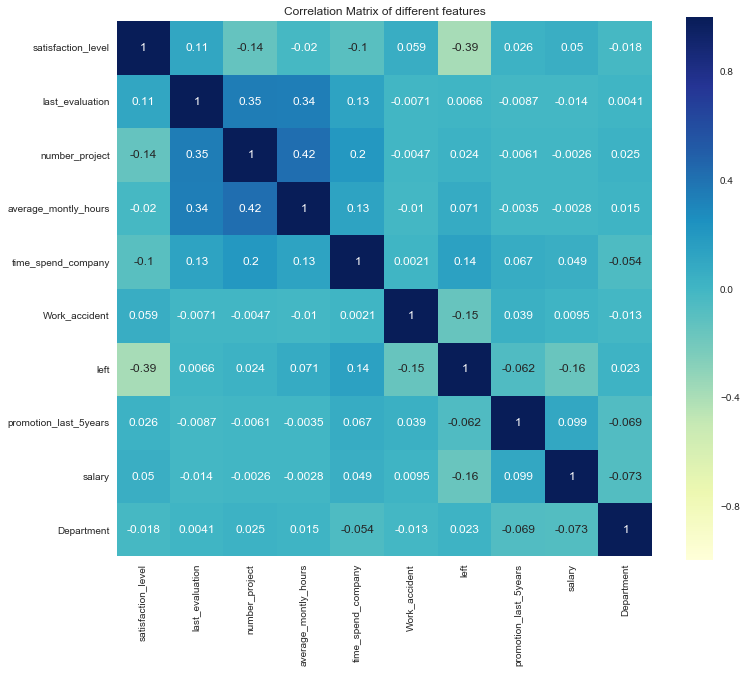

In [10]:
header = list(heatMapdata)
correlation = Statistics.corr(heatMapRDD, method="pearson")
df = pd.DataFrame(correlation, index=header, columns=header) 
plt.figure(figsize=(12, 10))

sns.heatmap(correlation,
            square=True,
            xticklabels=header,
            yticklabels=header,
            cmap="YlGnBu",
            annot=True,)
            #linewidths=.1)
sns.plt.title("Correlation Matrix of different features")

df #output the correlation table

In [11]:
visualizedf = dataset.toPandas()
visualizedf['Department'] = visualizedf['sales']
visualizedf.drop(['sales'], axis = 1, inplace = True)

In [12]:
evalMean = visualizedf['last_evaluation'].mean()
evalStd = np.std(visualizedf['last_evaluation'])
visualizedf['Performance(standard units)'] = (visualizedf['last_evaluation']- evalMean)/evalStd

In [13]:
def performance_label(row):
    performance = row['Performance(standard units)']
    if performance >=1:
        result = '>Average'
    else:
        result = '<=Average'
        
    return(result)

In [14]:
visualizedf['performance label'] = visualizedf.apply(performance_label, axis = 1)
left_dict = {1: 'left', 0: 'stayed'}
visualizedf['left(as_string)'] = (visualizedf['left'].map(left_dict))
visualizedf['salary_estimate'] = visualizedf['salary'].map(salary_dict)

In [15]:
columns = (visualizedf.columns)
num_columns = (visualizedf._get_numeric_data().columns)

hrData = visualizedf
hrData['Feature title'] = hrData['left(as_string)'] + ' : ' + hrData['performance label']

hrData_pivot = hrData.pivot_table(index= (['Feature title']), values =num_columns, aggfunc=np.mean)
hrData_pivot.transpose()

Feature title,left : <=Average,left : >Average,stayed : <=Average,stayed : >Average
Performance(standard units),-0.540078,1.352882,-0.326718,1.319193
Work_accident,0.050988,0.038425,0.175504,0.172983
average_montly_hours,187.898024,254.862632,198.254872,202.358003
label,1.000000,1.000000,0.000000,0.000000
last_evaluation,0.623660,0.947666,0.660180,0.941899
left,1.000000,1.000000,0.000000,0.000000
number_project,3.310672,5.179635,3.777137,3.825680
promotion_last_5years,0.007115,0.000961,0.026347,0.025858
salary_estimate,77015.810277,76340.057637,87348.938487,85818.100758
satisfaction_level,0.399787,0.538069,0.663585,0.680013


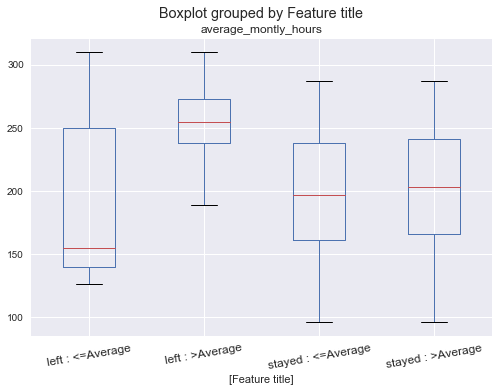

In [16]:
hrData[['Feature title', 'average_montly_hours']].boxplot(by = 'Feature title')
plt.xticks(rotation = 10)
plt.savefig('avg_hours_box_plot.png')
plt.show()

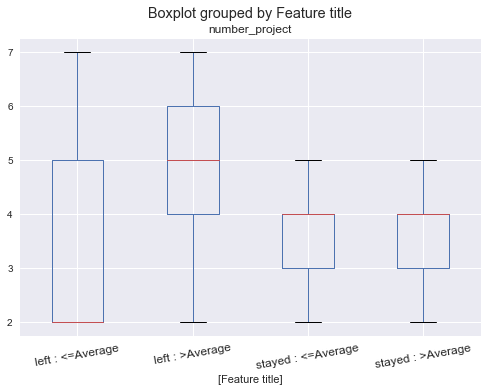

In [17]:
hrData[['Feature title', 'number_project']].boxplot(by = 'Feature title')
plt.xticks(rotation = 10)
plt.savefig('avg_project_box_plot.png')
plt.show()


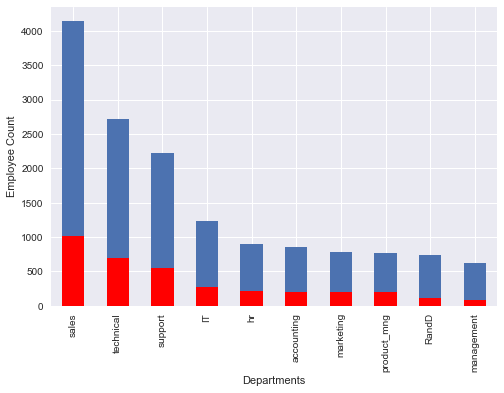

In [18]:
left_data = hrData[hrData.left == 1]
hrData.Department.value_counts().plot(kind='bar')
left_data.Department.value_counts().plot(kind='bar', color = 'red')
plt.title =('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.savefig('dept_wise_left_box_plot.png')
plt.show()


/Users/dylanbao/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


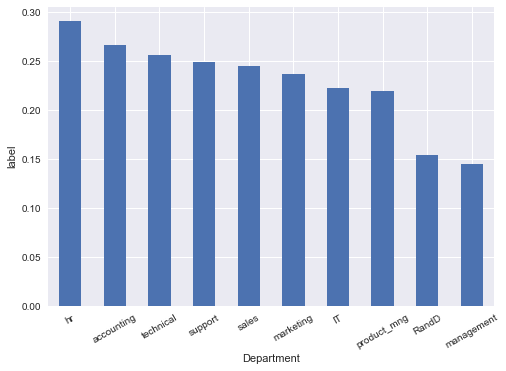

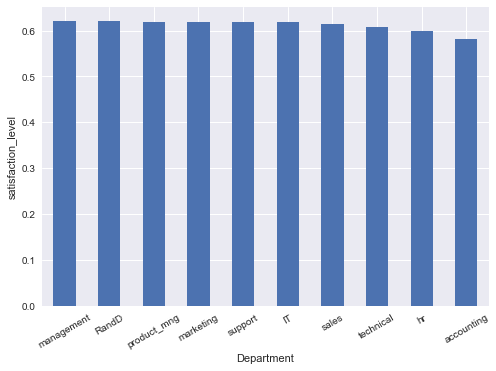

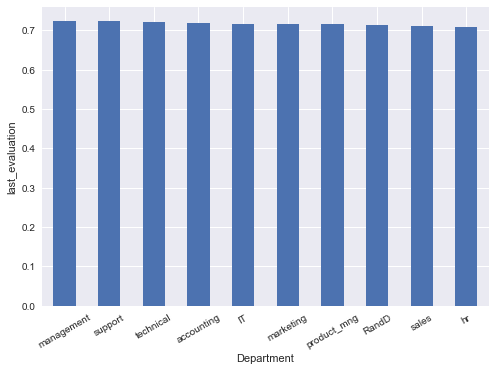

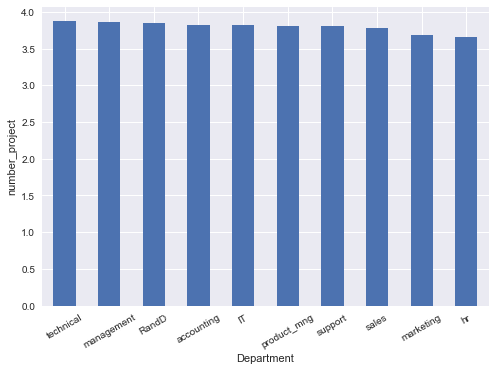

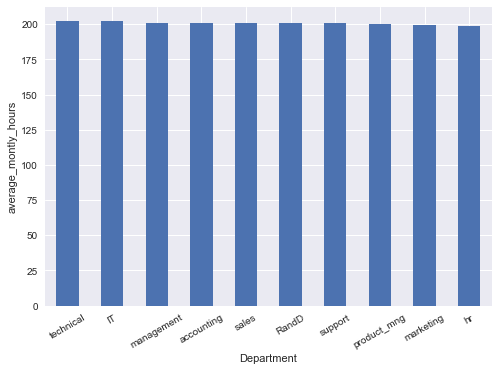

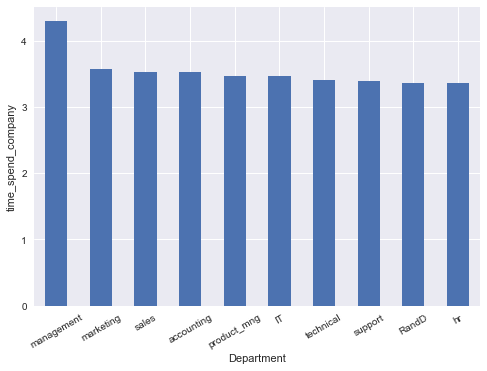

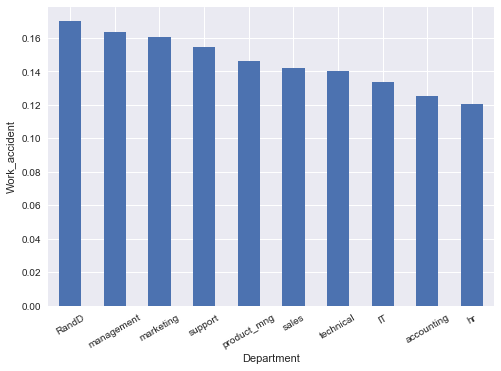

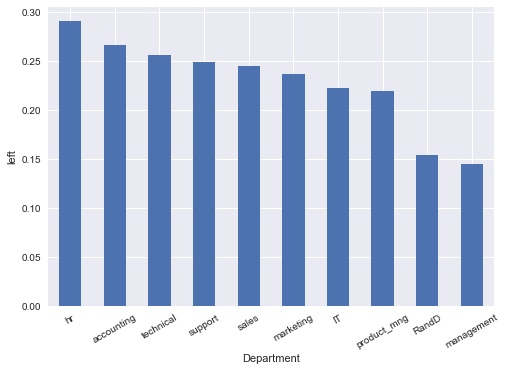

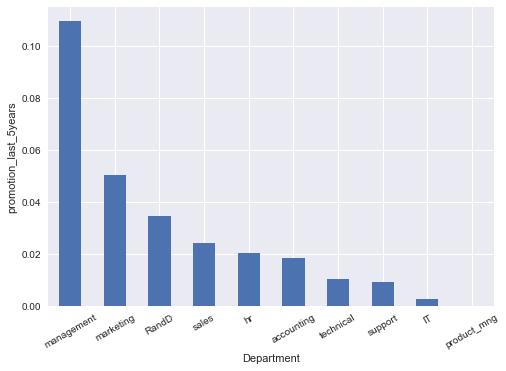

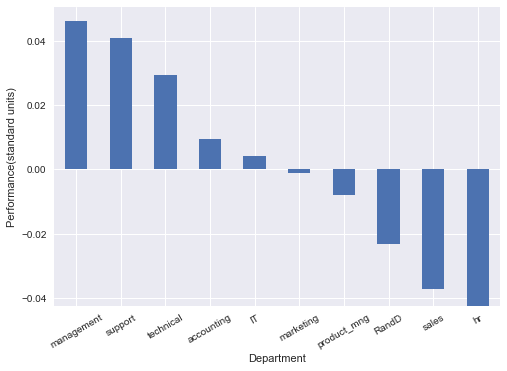

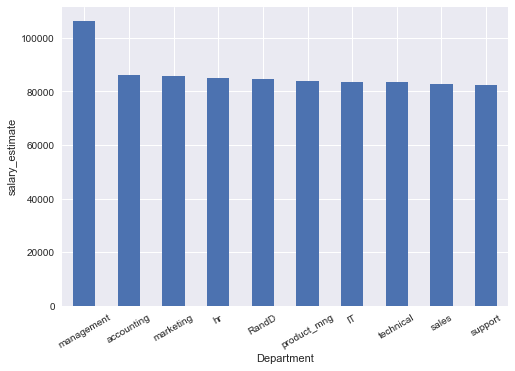

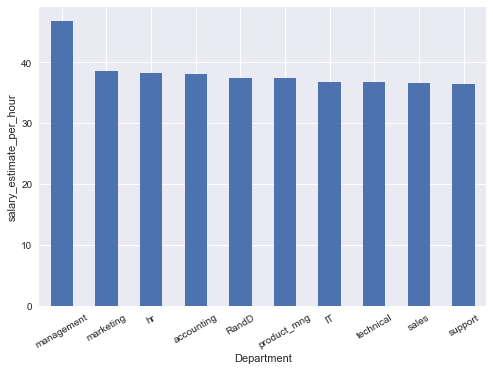

In [19]:
hrData['salary_estimate_per_hour'] = hrData.salary_estimate/(hrData.average_montly_hours *12)

hr_data_by_dept = hrData.groupby(['Department']).mean()

for col in hr_data_by_dept.columns:
    hr_data_sorted = hr_data_by_dept.sort(col, ascending = False)
    hr_data_sorted[col].plot(kind = 'bar')
    plt.ylabel(col)
    plt.xticks( rotation = 30)
    plt.savefig(col+'.png')
    plt.show()


## Plotting cumulative distributed function for the features

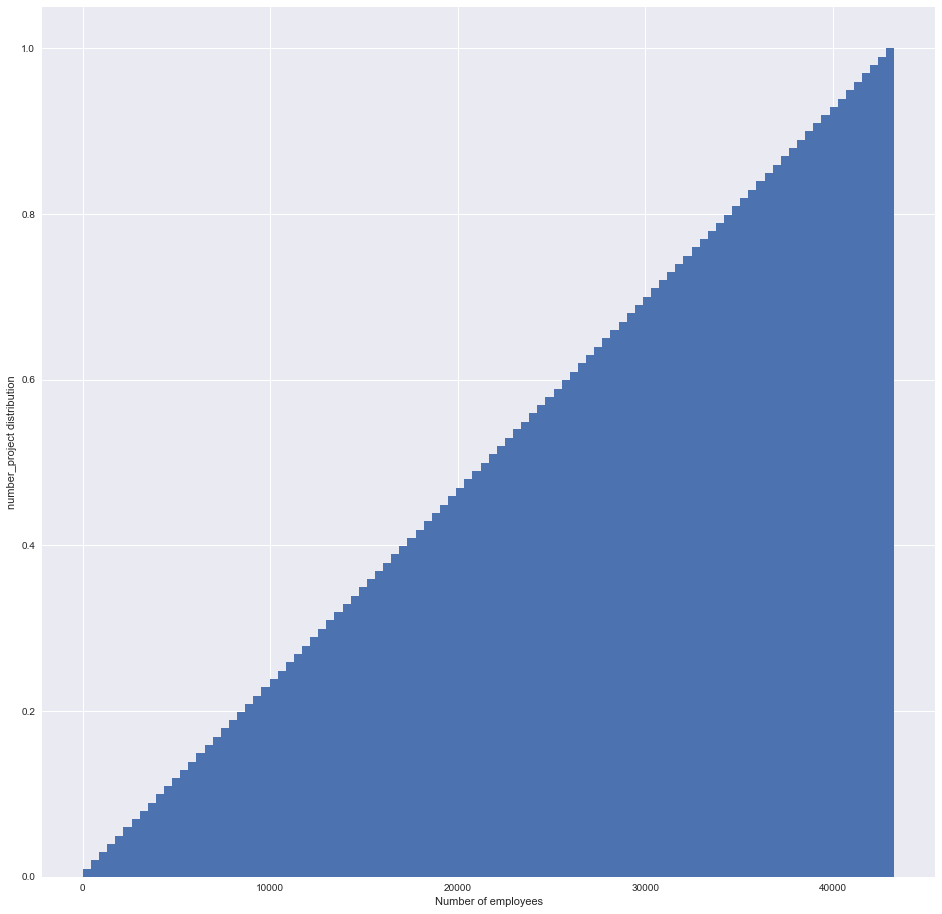

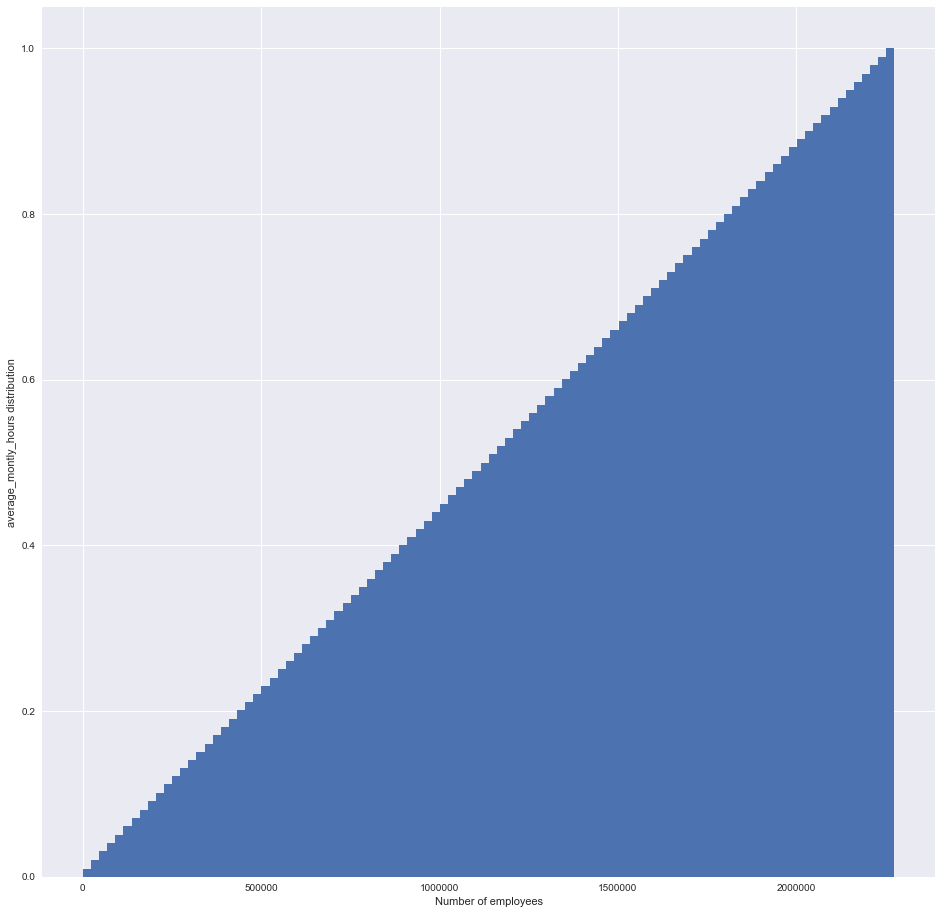

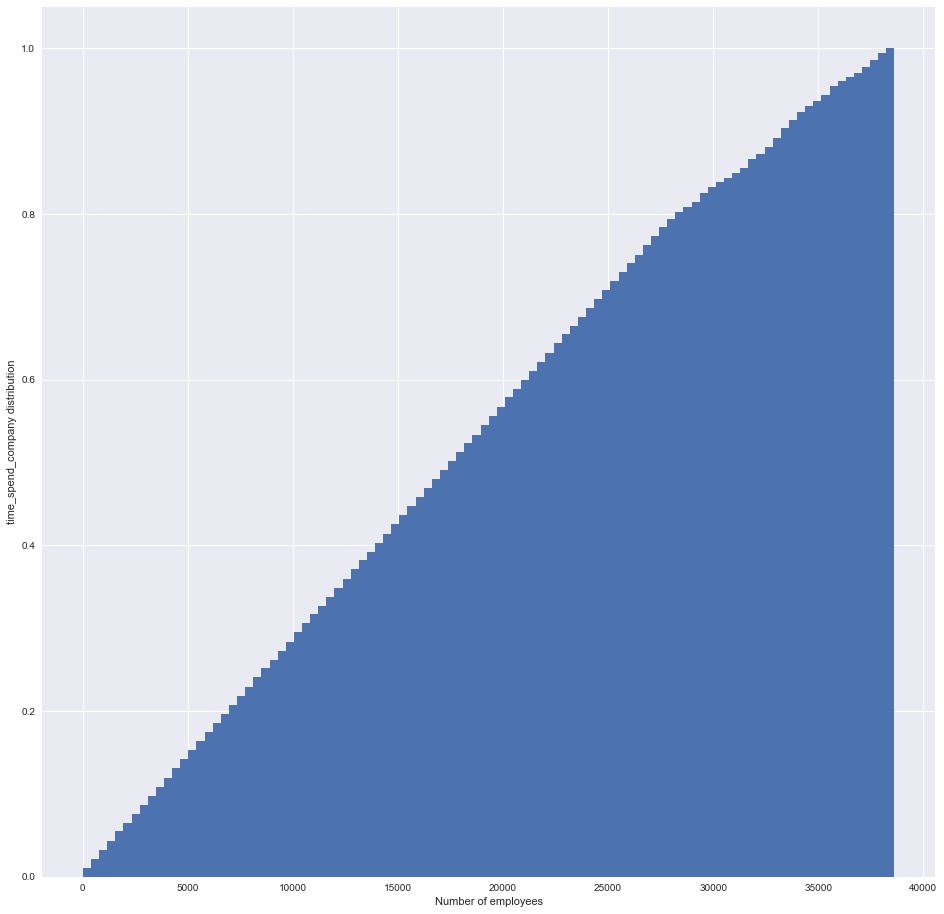

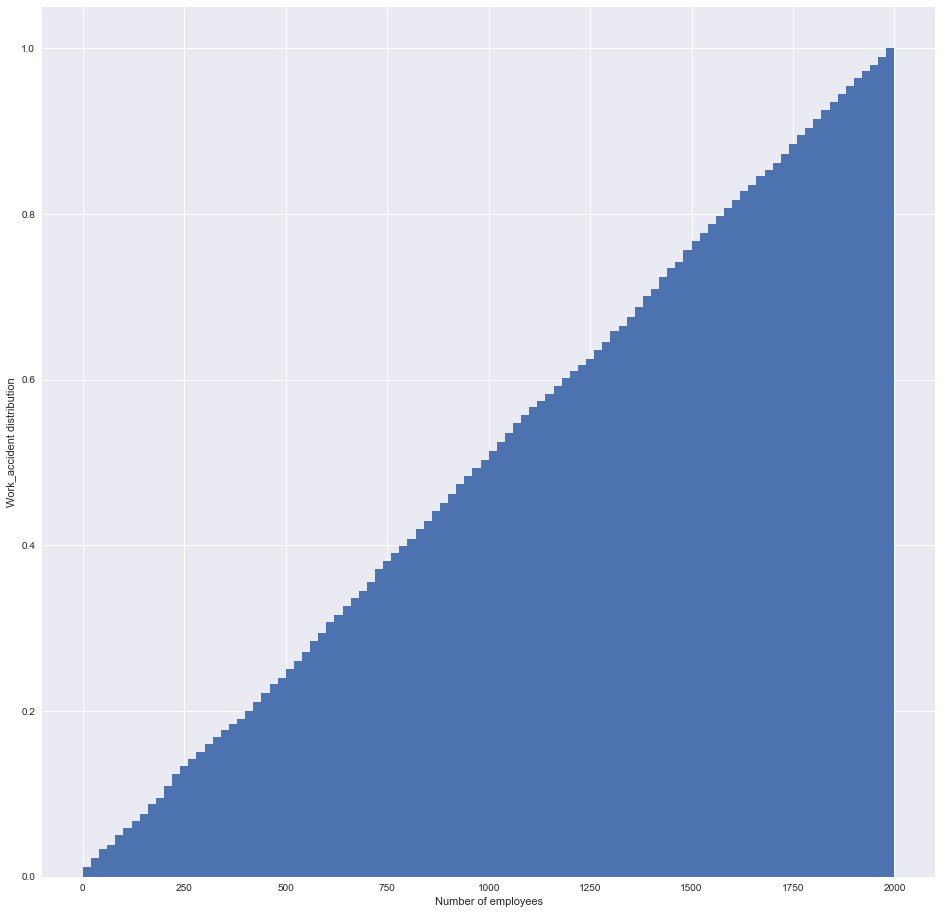

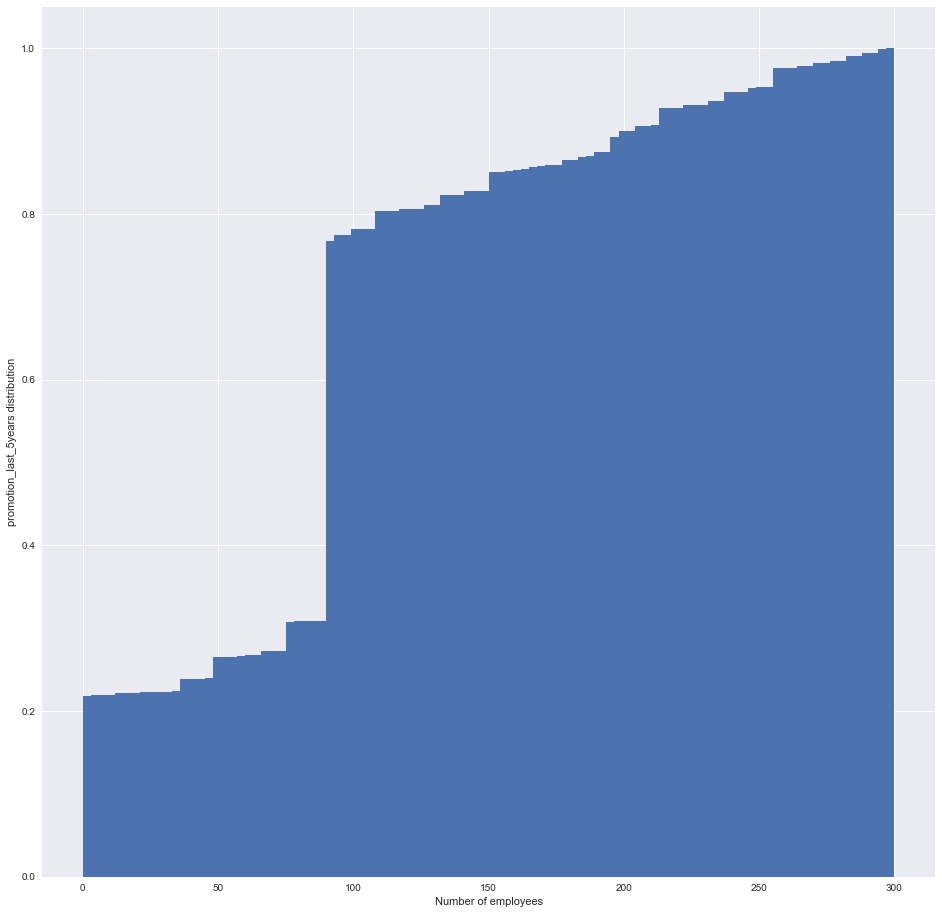

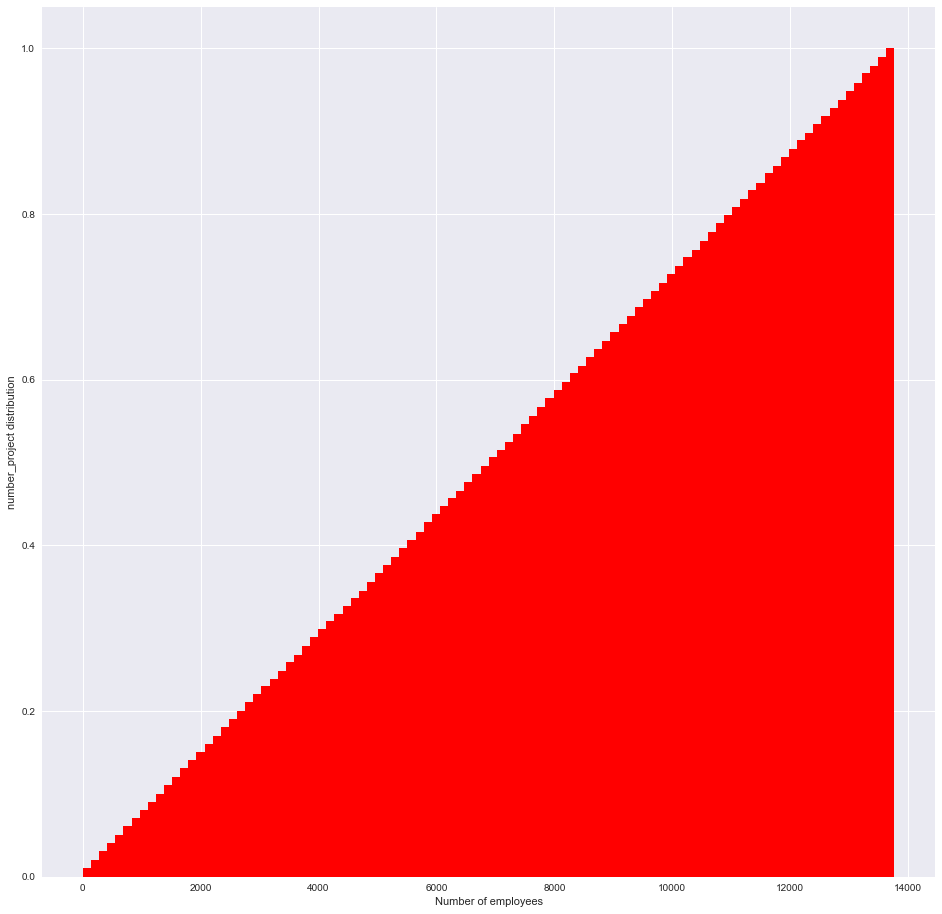

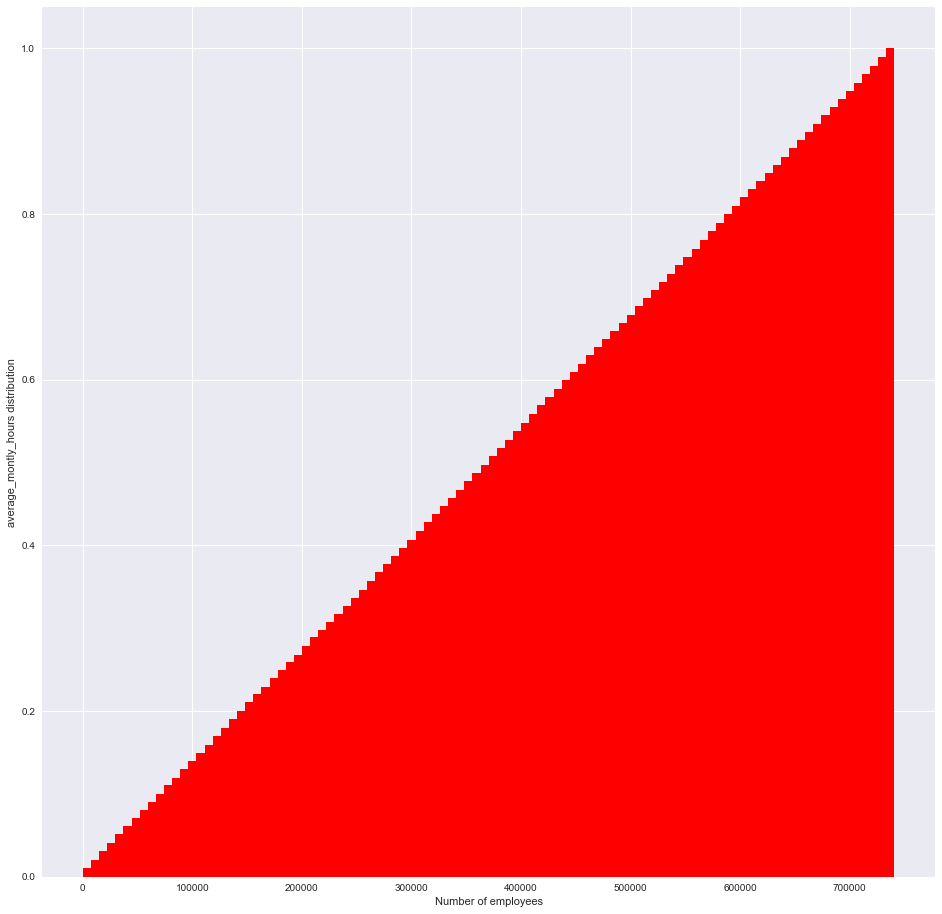

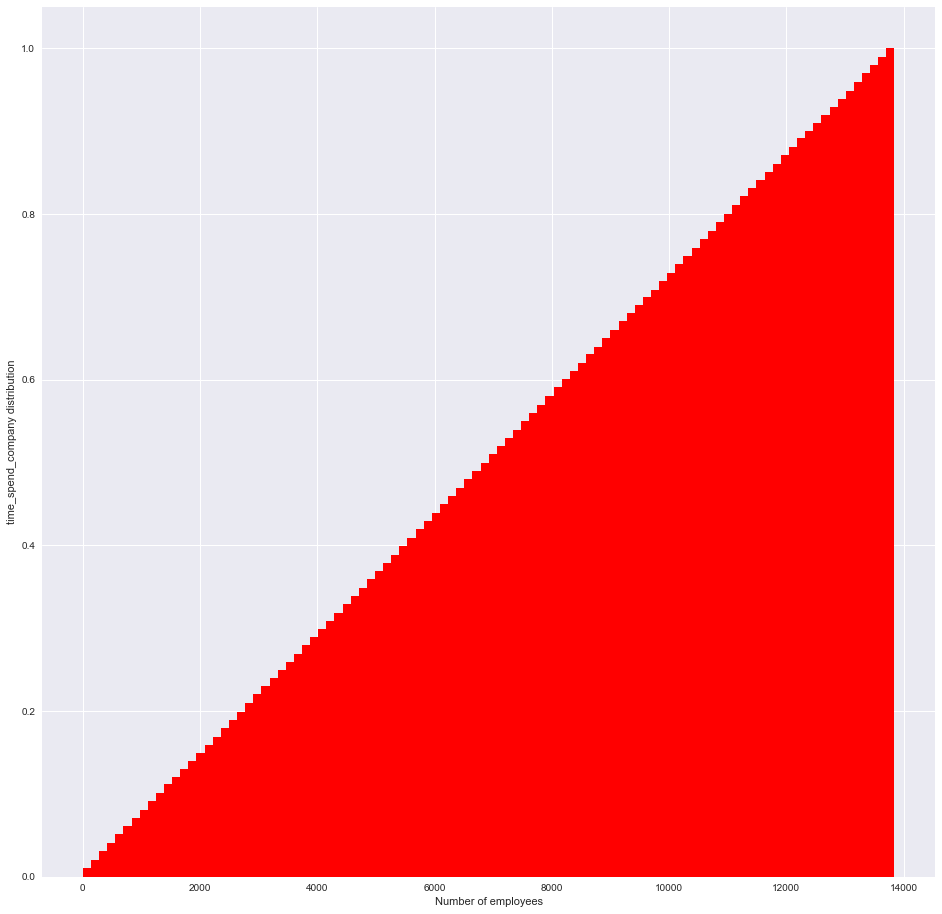

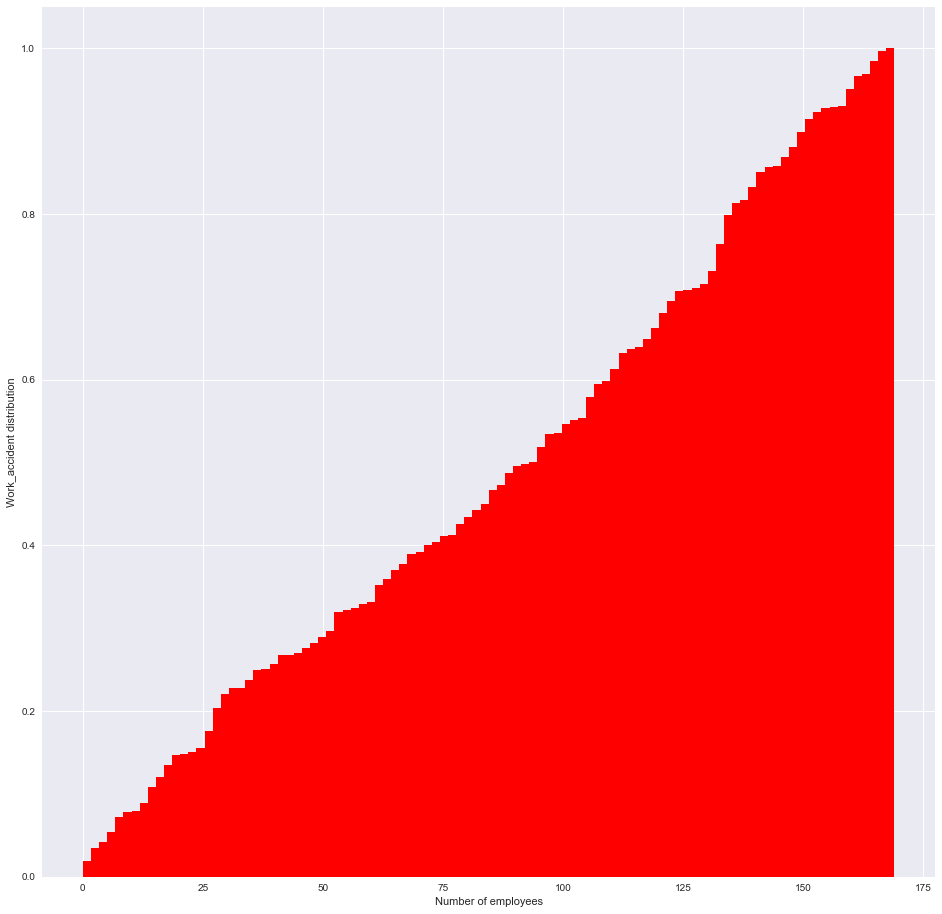

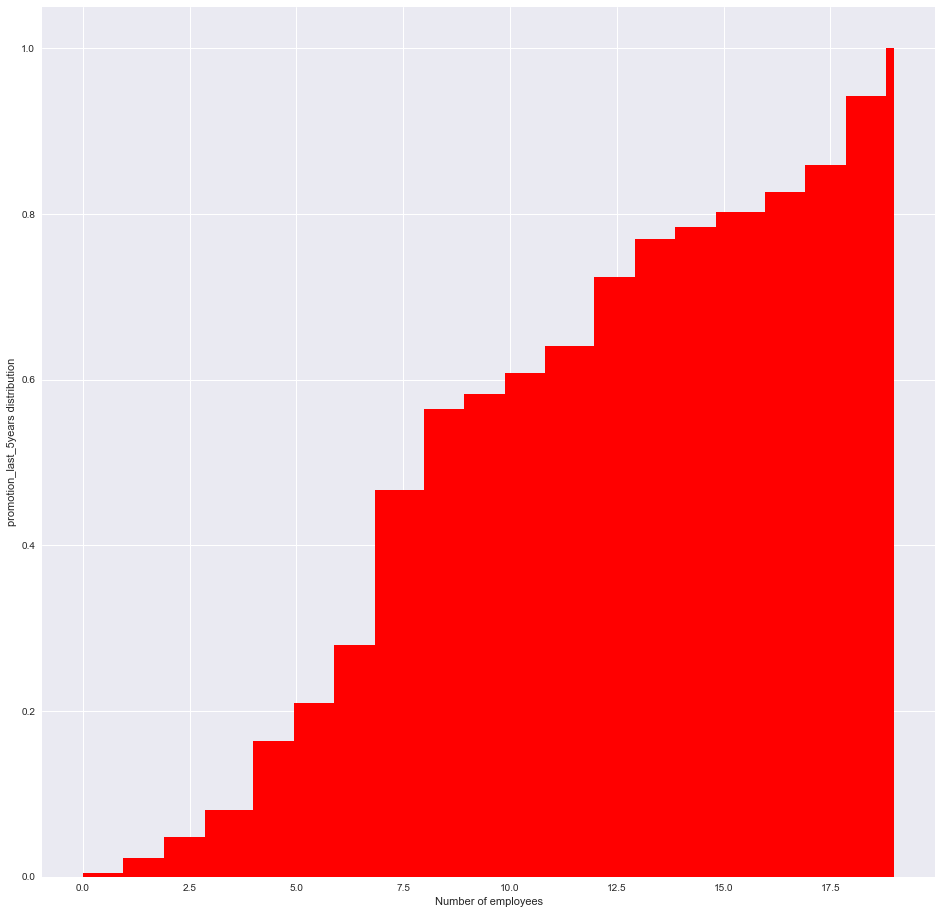

In [20]:
present = visualizedf.loc[visualizedf['left'] == 0]
quit = visualizedf.loc[visualizedf['left'] == 1]

for col in numericColumns:
    plt.figure(figsize=(16, 16))
    ser = pd.Series(present[col].cumsum())
    ser.hist(cumulative=True, normed=1, bins=100)
    plt.ylabel(col+" distribution")
    plt.xlabel("Number of employees")
    plt.savefig('present'+col+'.png')
    plt.show()
    
for col in numericColumns:
    plt.figure(figsize=(16, 16))
    ser = pd.Series(quit[col].cumsum())
    ser.hist(cumulative=True, normed=1, bins=100,color='r')
    plt.ylabel(col+" distribution")
    plt.xlabel("Number of employees")
    plt.savefig('quit'+col+'.png')
    plt.show()


## Helper functions for measuring the performance of classifiers

In [21]:
from __future__ import division
def measures(tp,tn,fp,fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1_score = (2*tp)/((2*tp)+fp+fn)
    return precision, recall, specificity, accuracy, f1_score

def howgoodisit(result):
    true_positives = result.filter(lambda line: line[1]==0.0 and line[0]==0.0).count()
    true_negatives = result.filter(lambda line: line[1]==1.0 and line[0]==1.0).count()
    false_positives = result.filter(lambda line: line[1]==0.0 and line[0]==1.0).count()
    false_negatives = result.filter(lambda line: line[1]==1.0 and line[0]==0.0).count()
    return measures(true_positives, true_negatives, false_positives, false_negatives)

## Training and test dataset

In [22]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print trainingData.count()
print testData.count()

10567
4432


## Fitting the dataset with various machine learning algorithms

In [23]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- sales: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [24]:
selected = predictions.select("label", "prediction", "probability")
selected.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.77697641302549...|
|  0.0|       0.0|[0.59339454079627...|
|  0.0|       0.0|[0.65793686279020...|
|  0.0|       0.0|[0.77017435807291...|
|  0.0|       0.0|[0.76106183794182...|
|  0.0|       0.0|[0.69795973045569...|
|  0.0|       0.0|[0.75281798642968...|
|  0.0|       0.0|[0.75226165823401...|
|  0.0|       0.0|[0.69289775060790...|
|  0.0|       0.0|[0.69289775060790...|
|  0.0|       0.0|[0.68586113805961...|
|  0.0|       0.0|[0.74153270537012...|
|  0.0|       0.0|[0.62076415096320...|
|  0.0|       0.0|[0.73576577328656...|
|  0.0|       0.0|[0.67678068206384...|
|  0.0|       0.0|[0.67547231581425...|
|  0.0|       0.0|[0.73109328439357...|
|  0.0|       0.0|[0.72814659424960...|
|  0.0|       0.0|[0.52874904179595...|
|  0.0|       0.0|[0.59081153751529...|
+-----+----------+--------------------+
only showing top 20 rows



In [26]:
test = predictions.select("label", "prediction")
testRdd = test.rdd.map(list)

[precision, recall, specificity, accuracy, f1_score] = howgoodisit(testRdd)
#print precision, recall, specificity, accuracy, f1_score
print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.762534818942
recall:  0.973621813871
specificity:  0.0330812854442
accuracy:  0.749097472924
f1_score:  0.85524602968


## Evaluating logistic regression

In [27]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)

areaUnderROC
0.719831991107
areaUnderPR
0.379709825066


In [28]:
lr_preds_and_labels = predictions.select("label", "prediction").rdd.map(list)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(lr_preds_and_labels)
#print precision, recall, specificity, accuracy, f1_score
print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.762534818942
recall:  0.973621813871
specificity:  0.0330812854442
accuracy:  0.749097472924
f1_score:  0.85524602968


## Crossvalidation on logistic regression model

In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5,1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [100, 500, 1000])
             .build())

In [30]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
#numFolds=10 indicates 10-fold cross validation.

In [31]:
cvModel = cv.fit(trainingData)

In [32]:
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)

0.6193592057761733

In [33]:
print 'Model Intercept: ', cvModel.bestModel.intercept
weights = cvModel.bestModel.coefficients
weights = map(lambda w: (float(w),), weights)  # convert numpy type to float, and to tuple
selected = predictions.select("label", "prediction", "probability")
selected.show()

Model Intercept:  -1.16469160387
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
+-----+----------+--------------------+
only sh

In [34]:
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)

areaUnderPR
0.619359205776
areaUnderPR
0.619359205776


In [38]:
predAndlabel = predictions.select("label", "prediction").rdd.map(list)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(predAndlabel)

print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.761281588448
recall:  1.0
specificity:  0.0
accuracy:  0.761281588448
f1_score:  0.86446323341


## SVM Classifier

In [39]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.ml import linalg as ml_linalg
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

In [40]:
def as_mllib(v):
    if isinstance(v, ml_linalg.SparseVector):
        return MLLibVectors.sparse(v.size, v.indices, v.values)
    elif isinstance(v, ml_linalg.DenseVector):
        return MLLibVectors.dense(v.toArray())
    else:
        raise TypeError("Unsupported type: {0}".format(type(v)))

In [41]:
parsedTrainData = trainingData.select("label", "features").rdd.map(list).map(lambda x : LabeledPoint(x[0],as_mllib(x[1])))
parsedTestData = testData.select("label", "features").rdd.map(list).map(lambda x : LabeledPoint(x[0],as_mllib(x[1])))


modelSVM = SVMWithSGD.train(parsedTrainData, iterations=1000)

labelsAndPreds_SVMtrain = parsedTrainData.map(lambda p: [p.label, modelSVM.predict(p.features)])
#howgoodisit(labelsAndPreds_SVMtrain)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(labelsAndPreds_SVMtrain)

print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.762184158228
recall:  1.0
specificity:  0.0
accuracy:  0.762184158228
f1_score:  0.865044841845


In [42]:
#test data evaluation
labelsAndPreds_SVMtest = parsedTestData.map(lambda p: (p.label, modelSVM.predict(p.features)))
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(labelsAndPreds_SVMtest)

print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.761281588448
recall:  1.0
specificity:  0.0
accuracy:  0.761281588448
f1_score:  0.86446323341


# Deicision Tree

In [43]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=4)

# Train model with Training Data
dtModel = dt.fit(trainingData)

print "numNodes = ", dtModel.numNodes
print "depth = ", dtModel.depth

# Make predictions on test data using the Transformer.transform() method.
predictions = dtModel.transform(testData)
predictions.printSchema()

numNodes =  29
depth =  4
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- sales: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [44]:
# View model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability")
selected.show()


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       1.0|[0.09314140558848...|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       1.0|[0.09314140558848...|
|  0.0|       1.0|[0.09314140558848...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
|  0.0|       0.0|[0.98165137614678...|
+-----+----------+--------------------+
only showing top 20 rows



In [45]:
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)


0.9335259176421944

In [46]:
DTree = dtModel.toDebugString
print DTree

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4c15bd26b586548ad393) of depth 4 with 29 nodes
  If (feature 11 <= 2.0)
   If (feature 12 <= 164.0)
    If (feature 12 <= 124.0)
     Predict: 0.0
    Else (feature 12 > 124.0)
     If (feature 13 <= 2.0)
      Predict: 0.0
     Else (feature 13 > 2.0)
      Predict: 1.0
   Else (feature 12 > 164.0)
    If (feature 12 <= 240.0)
     If (feature 1 in {0.0})
      Predict: 0.0
     Else (feature 1 not in {0.0})
      Predict: 0.0
    Else (feature 12 > 240.0)
     If (feature 0 in {0.0})
      Predict: 0.0
     Else (feature 0 not in {0.0})
      Predict: 0.0
  Else (feature 11 > 2.0)
   If (feature 13 <= 3.0)
    If (feature 12 <= 283.0)
     If (feature 11 <= 6.0)
      Predict: 0.0
     Else (feature 11 > 6.0)
      Predict: 1.0
    Else (feature 12 > 283.0)
     If (feature 14 <= 0.0)
      Predict: 1.0
     Else (feature 14 > 0.0)
      Predict: 0.0
   Else (feature 13 > 3.0)
    If (feature 12 <= 219.0)
     If (feature 12

## Transfer data to json format(decision tree)

In [47]:
import json
from bson import json_util
from bson.json_util import dumps

In [48]:
# Parser
def parse(lines):
    block = []
    while lines :

        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name':bl, 'children':parse(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name':be, 'children':parse(lines)})
        elif not lines[0].startswith(('If','Else')):
            block2 = lines.pop(0)
            block.append({'name':block2})
        else:
            break
    return block

In [49]:
def tree_json(tree):
    data = []
    for line in tree.splitlines() : 
        if line.strip():
            line = line.strip()
            data.append(line)
        else : break
        if not line : break
    res = []
    res.append({'name':'Root', 'children':parse(data[1:])})
    with open('/Users/dylanbao/Desktop/SJSU/297ML/Project/Decision-Tree-Visualization-Spark-master/data/structure.json', 'w') as outfile:
        json.dump(res[0], outfile)
    print ('Conversion Success !')

In [50]:
tree_json(DTree)

Conversion Success !


## Evaluate the Model

In [51]:
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)

areaUnderROC
0.933525917642
areaUnderPR
0.872263034426


In [52]:
#predication evaluation
DT_preds_and_labels = predictions.select("label", "prediction").rdd.map(list)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(DT_preds_and_labels)
print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.952
recall:  0.952282157676
specificity:  0.846880907372
accuracy:  0.927120938628
f1_score:  0.952141057935


## Crossvalidation on Decision Tree

In [53]:
# Create ParamGrid for Cross Validation

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,6,10])
             .addGrid(dt.maxBins, [20,40,80])
             .build())


In [54]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

print "numNodes = ", cvModel.bestModel.numNodes
print "depth = ", cvModel.bestModel.depth

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

numNodes =  497
depth =  10


0.896319921308404

In [55]:
# View Best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability")
selected.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       1.0|[0.01932367149758...|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
+-----+----------+--------------------+
only showing top 20 rows



In [56]:
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)


areaUnderPR
0.896319921308
areaUnderPR
0.896319921308


In [57]:
#predication evaluation
DTV_preds_and_labels = predictions.select("label", "prediction").rdd.map(list)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(DTV_preds_and_labels)
print "precision: ", precision
print "recall: ", recall
print "specificity: ", specificity
print "accuracy: ", accuracy
print "f1_score: ", f1_score

precision:  0.971504897596
recall:  0.970065204505
specificity:  0.909262759924
accuracy:  0.955550541516
f1_score:  0.970784517277


# Random Forest Algorithm

In [59]:
from pyspark.ml.classification import RandomForestClassifier as RF
rf = RF(labelCol="label", featuresCol="features",numTrees=3)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

In [60]:
selected = transformed.select("label", "prediction",  "probability")
selected.show()
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=3): ", metrics.areaUnderROC)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[0.44941686609916...|
|  0.0|       1.0|[0.31152456882009...|
|  0.0|       1.0|[0.31152456882009...|
|  0.0|       1.0|[0.44941686609916...|
|  0.0|       1.0|[0.44941686609916...|
|  0.0|       1.0|[0.31152456882009...|
|  0.0|       1.0|[0.44941686609916...|
|  0.0|       1.0|[0.44941686609916...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.67870470300377...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.67870470300377...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.67870470300377...|
|  0.0|       0.0|[0.67870470300377...|
|  0.0|       0.0|[0.54081240572470...|
|  0.0|       0.0|[0.54081240572470...|
+-----+----------+--------------------+
only showing top 20 rows

('The ROC scor

In [61]:
from numpy.random import randint
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
 
RATIO_ADJUST = 2.0 ## ratio of pos to neg in the df_subsample
 
counts = trainingData.select('label').groupBy('label').count().collect()
higherBound = counts[0][1]
TRESHOLD_TO_FILTER = int(RATIO_ADJUST * float(counts[1][1]) / counts[0][1] * higherBound)
 
randGen = lambda x: randint(0, higherBound) if x == 'Positive' else -1
 
udfRandGen = udf(randGen, IntegerType())
trainingData = trainingData.withColumn("randIndex", udfRandGen("label"))
df_subsample = trainingData.filter(trainingData['randIndex'] < TRESHOLD_TO_FILTER)
df_subsample = df_subsample.drop('randIndex')
 
print("Distribution of Pos and Neg cases of the down-sampled training data are: \n", df_subsample.groupBy("label").count().take(3))

('Distribution of Pos and Neg cases of the down-sampled training data are: \n', [Row(label=0.0, count=8054), Row(label=1.0, count=2513)])


## Evaluating Random Forest Algorithm with cross validation

In [62]:
from numpy.random import randint
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
import numpy as np
RATIO_ADJUST = 3.0 ## ratio of pos to neg in the df_subsample
TOTAL_MODELS = 10
total_results = None
final_result = None
 
#counts = trainingData.select('binary_response').groupBy('binary_response').count().collect()
highestBound = counts[0][1]
TRESHOLD_TO_FILTER = int(RATIO_ADJUST * float(counts[1][1]) / counts[0][1] * highestBound)
## UDF
randGen = lambda x: randint(0, highestBound) if x == 'Positive' else -1
udfRandGen = udf(randGen, IntegerType())
 
## ensembling
for N in range(TOTAL_MODELS):
    print("Round: ", N)
    trainingDataIndexed = trainingData.withColumn("randIndex", udfRandGen("label"))
    df_subsample = trainingDataIndexed.filter(trainingDataIndexed['randIndex'] < TRESHOLD_TO_FILTER).drop('randIndex')
    ## training and prediction
    rf = RF(labelCol='label', featuresCol='features',numTrees=3)
    fit = rf.fit(df_subsample)
    transformed = fit.transform(testData)
    result_pair = transformed.select(['probability', 'label'])
    result_pair = result_pair.collect()
    this_result = np.array([float(i[0][1]) for i in result_pair])
    this_result = list(this_result.argsort().argsort() / (float(len(this_result) + 1)))
 
    ## sum up all the predictions, and average to get final_result
    if total_results is None:
       total_results = this_result
    else:
       total_results = [i+j for i, j in zip(this_result, total_results)]
    final_result = [i/(N+1) for i in total_results]
 
    results_list = [(float(i), float(j[1])) for i, j in zip(final_result, result_pair)]
    scoreAndLabels = sc.parallelize(results_list)
 
    metrics = metric(scoreAndLabels)
    print("The ROC score is (@numTrees=3): ", metrics.areaUnderROC)

('Round: ', 0)
('The ROC score is (@numTrees=3): ', 0.9069653628380249)
('Round: ', 1)
('The ROC score is (@numTrees=3): ', 0.9069653628380262)
('Round: ', 2)
('The ROC score is (@numTrees=3): ', 0.9069653628380265)
('Round: ', 3)
('The ROC score is (@numTrees=3): ', 0.9069653628380268)
('Round: ', 4)
('The ROC score is (@numTrees=3): ', 0.9069653628380266)
('Round: ', 5)
('The ROC score is (@numTrees=3): ', 0.9069653628380262)
('Round: ', 6)
('The ROC score is (@numTrees=3): ', 0.9069653628380241)
('Round: ', 7)
('The ROC score is (@numTrees=3): ', 0.9069653628380261)
('Round: ', 8)
('The ROC score is (@numTrees=3): ', 0.9069653628380266)
('Round: ', 9)
('The ROC score is (@numTrees=3): ', 0.9069653628380252)


## get importance for each feature with randomforestclassifier

In [64]:
#(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
rf = RF(labelCol="label", featuresCol="features", numTrees=3)
testModel = rf.fit(testData)
print testModel.featureImportances

(16,[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15],[0.000129823724171,0.00569215970544,0.000223504668278,0.000718568249055,0.000883115091835,3.03148041985e-05,0.00364398097838,0.00190364309784,0.00427324658521,0.00764704438147,0.398179059702,0.186489393211,0.314207307338,0.0739449756123,0.00203386285009])
